# Milestone 2

In [ ]:
# To display images
from IPython import display

Group 47

Members: Ask Winther Skåre &lt;qvk363, Jacob Lenzing &lt;whl784&gt;

# Task 1

Creating the working database for the FakeNewsCorpus the 1-million raw row data from Absalon was downloaded and loaded directly into Datagrip (used to manage the database and recommended by TA's). We managed to load 995.240 rows into the database before the computer crashed which lead us to working with that. 

Design wise we chose to exclude certain columns, because we assessed a minimal importance and therefore could keep our data clean(-er). We removed meta_descriptions, tags, summary, and source.   &nbsp;
Our solution therefore supports simple queries since we have managed to retrieve and manipulate data from our set. &nbsp;

Using Python to write SQL queries the package psycopg2 was used to connect to the Postgres server with the code:


In [ ]:
import psycopg2
conn = psycopg2.connect("host=localhost dbname=postgres user=postgres password=postgres")
cur = conn.cursor()

Here a connection is established with logon information defined in Datagrip. The 'cursor' is used to perform SQL queries in the python code. A lot of queries creating tables for the different types, authors, authors and url which are fake type, articles with their type and content were created. The Python code for the creation of all tables are seen in the following. In all tables the ID are also included since they are unique and can be used to differentiate when e.g. types are the same. 

In [ ]:
conn = psycopg2.connect("host=localhost dbname=postgres user=postgres password=postgres")
cur = conn.cursor()

cur.execute("""
CREATE TABLE authors AS
SELECT id, authors
FROM fulldata
""")

cur.execute("""
CREATE TABLE articles_types_content AS
SELECT id, type, title, content
FROM fulldata
""")

cur.execute("""
CREATE TABLE fake_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'fake')
""")

cur.execute("""
CREATE TABLE satire_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'satire')
""")

cur.execute("""
CREATE TABLE bias_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'bias')
""")

cur.execute("""
CREATE TABLE conspiracy_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'conspiracy')
""")

cur.execute("""
CREATE TABLE junksci_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'junksci')
""")

cur.execute("""
CREATE TABLE hate_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'hate')
""")

cur.execute("""
CREATE TABLE clickbait_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'clickbait')
""")

cur.execute("""
CREATE TABLE unreliable_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'unreliable')
""")

cur.execute("""
CREATE TABLE political_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'political')
""")

cur.execute("""
CREATE TABLE reliable_type AS
(SELECT id, type, title, authors
FROM fulldata
WHERE type = 'reliable')
""")

cur.execute("""
CREATE TABLE authors_url_fake AS
(SELECT id, authors, url, type
FROM fulldata
WHERE type = 'fake')
""")

conn.commit()
cur.close()

### Screenshot of working database

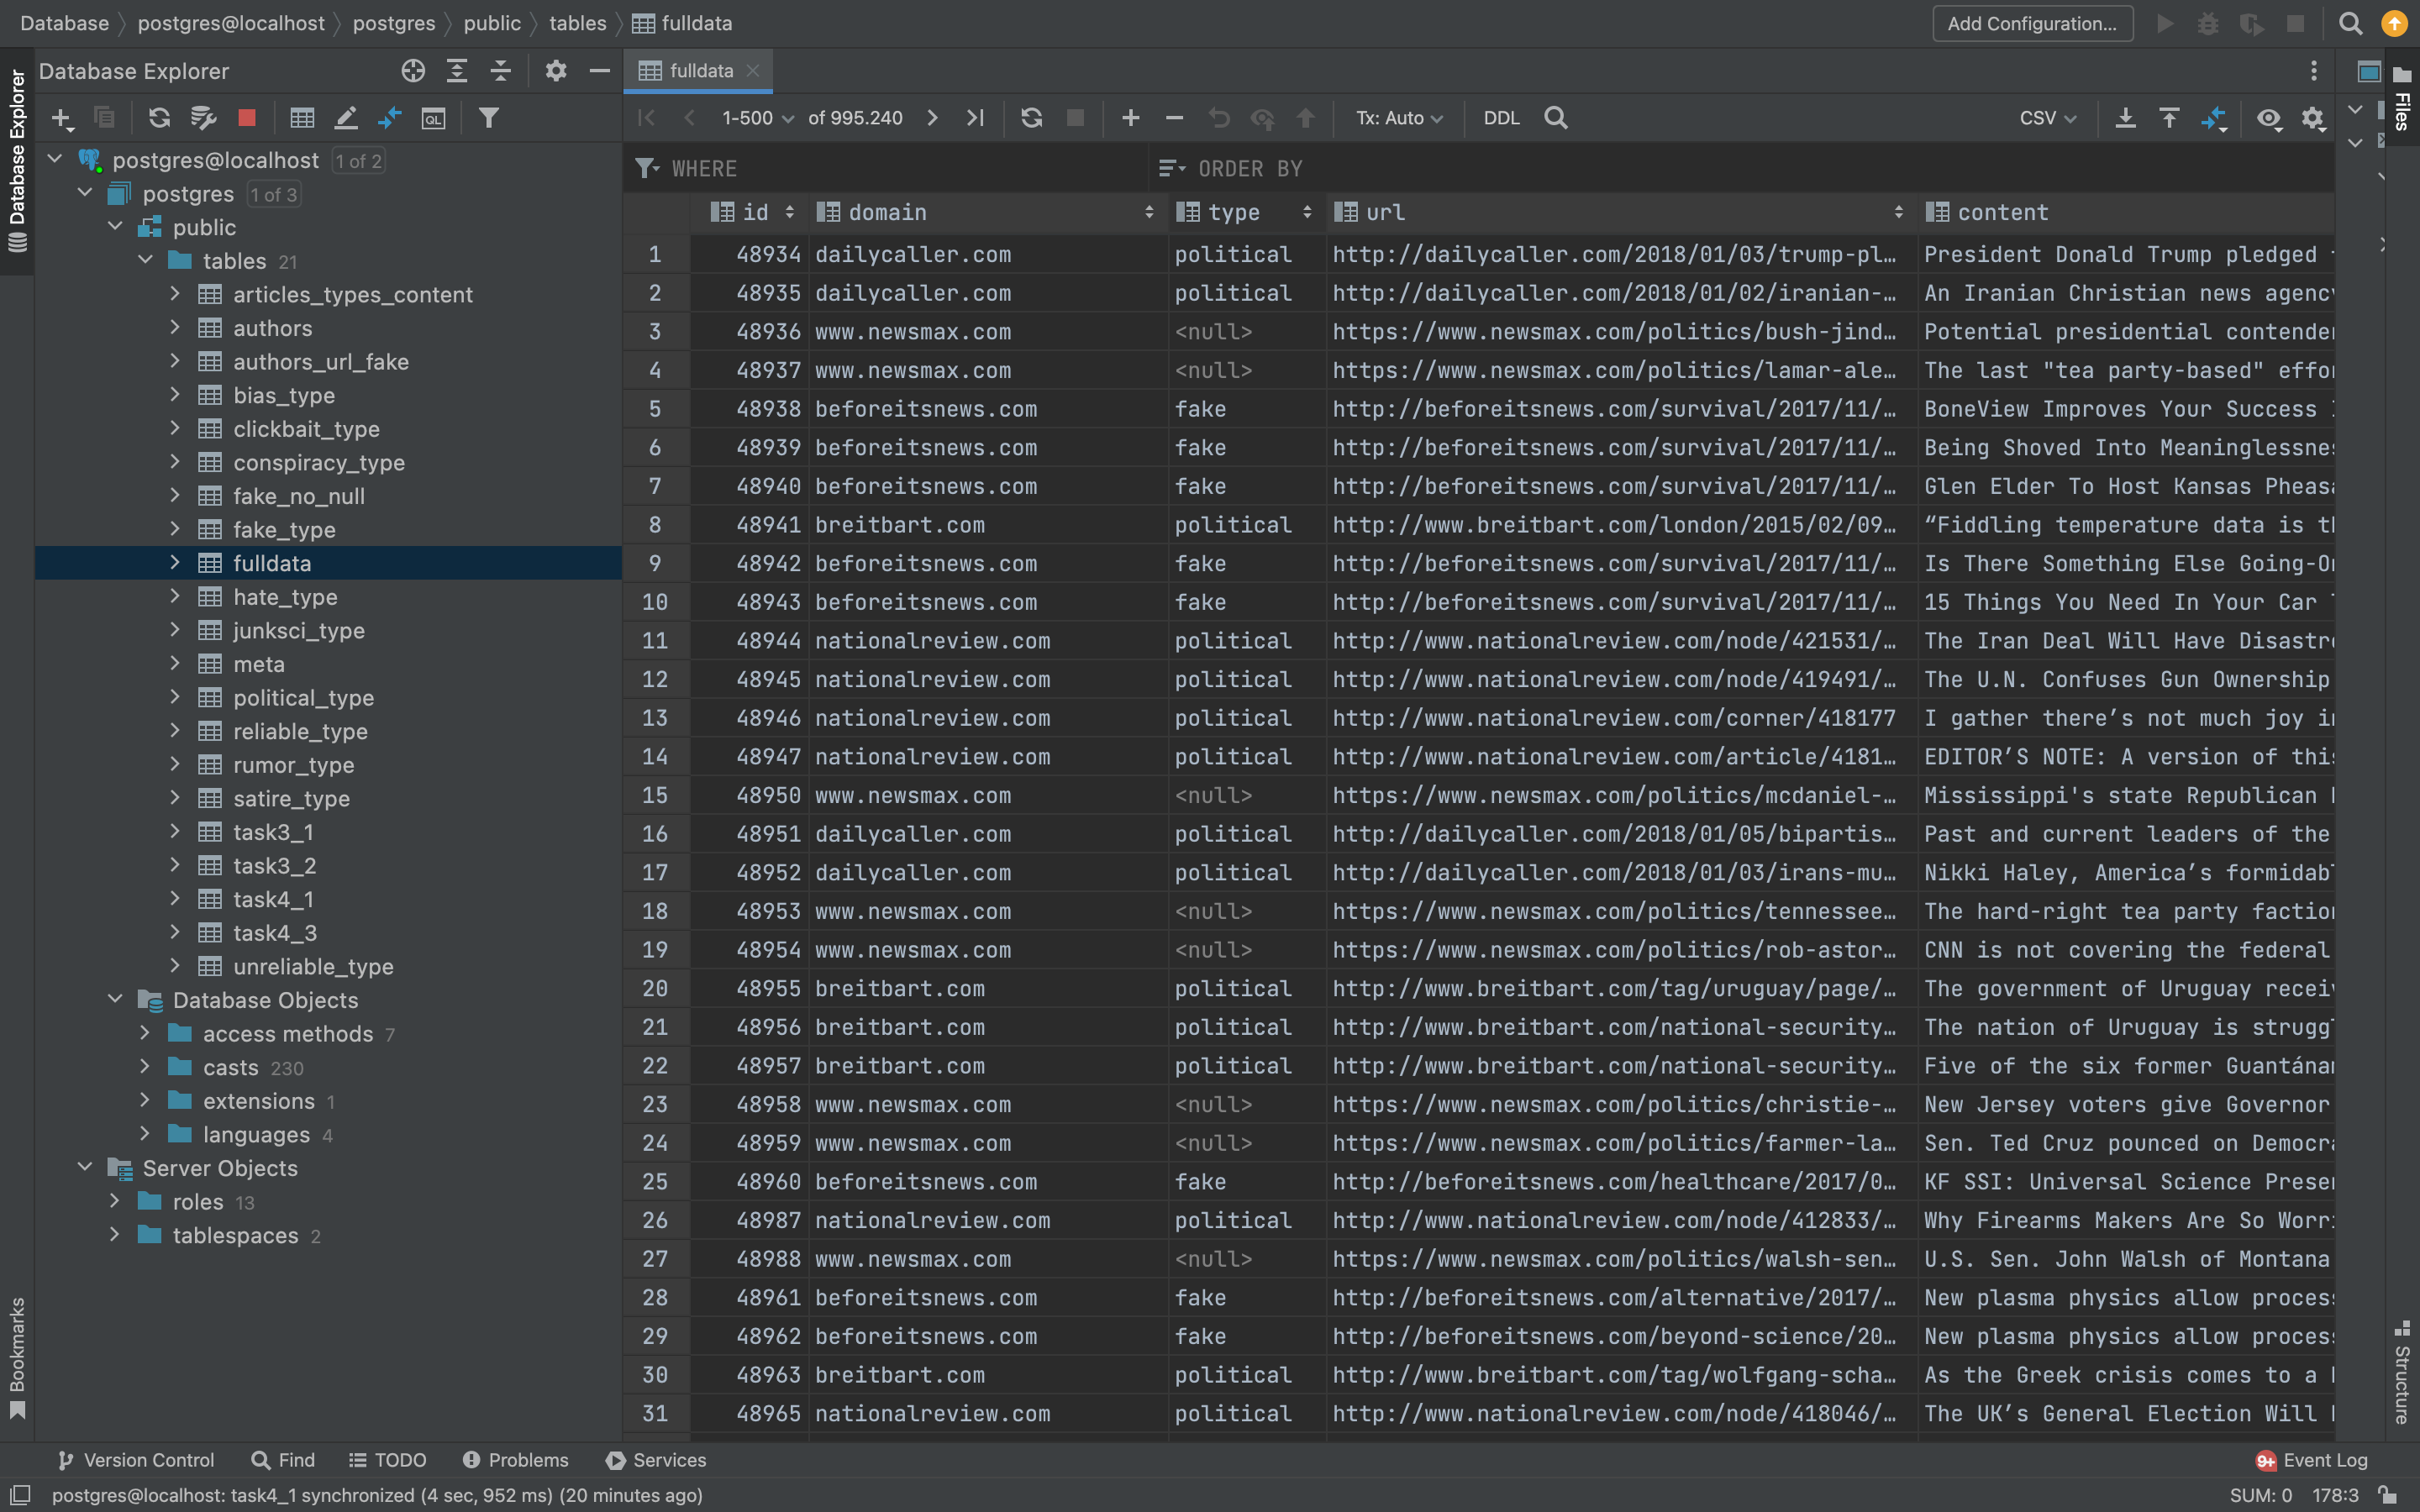

In [ ]:
display.Image("/work/database.png")

### Screenshot of relational diagrams

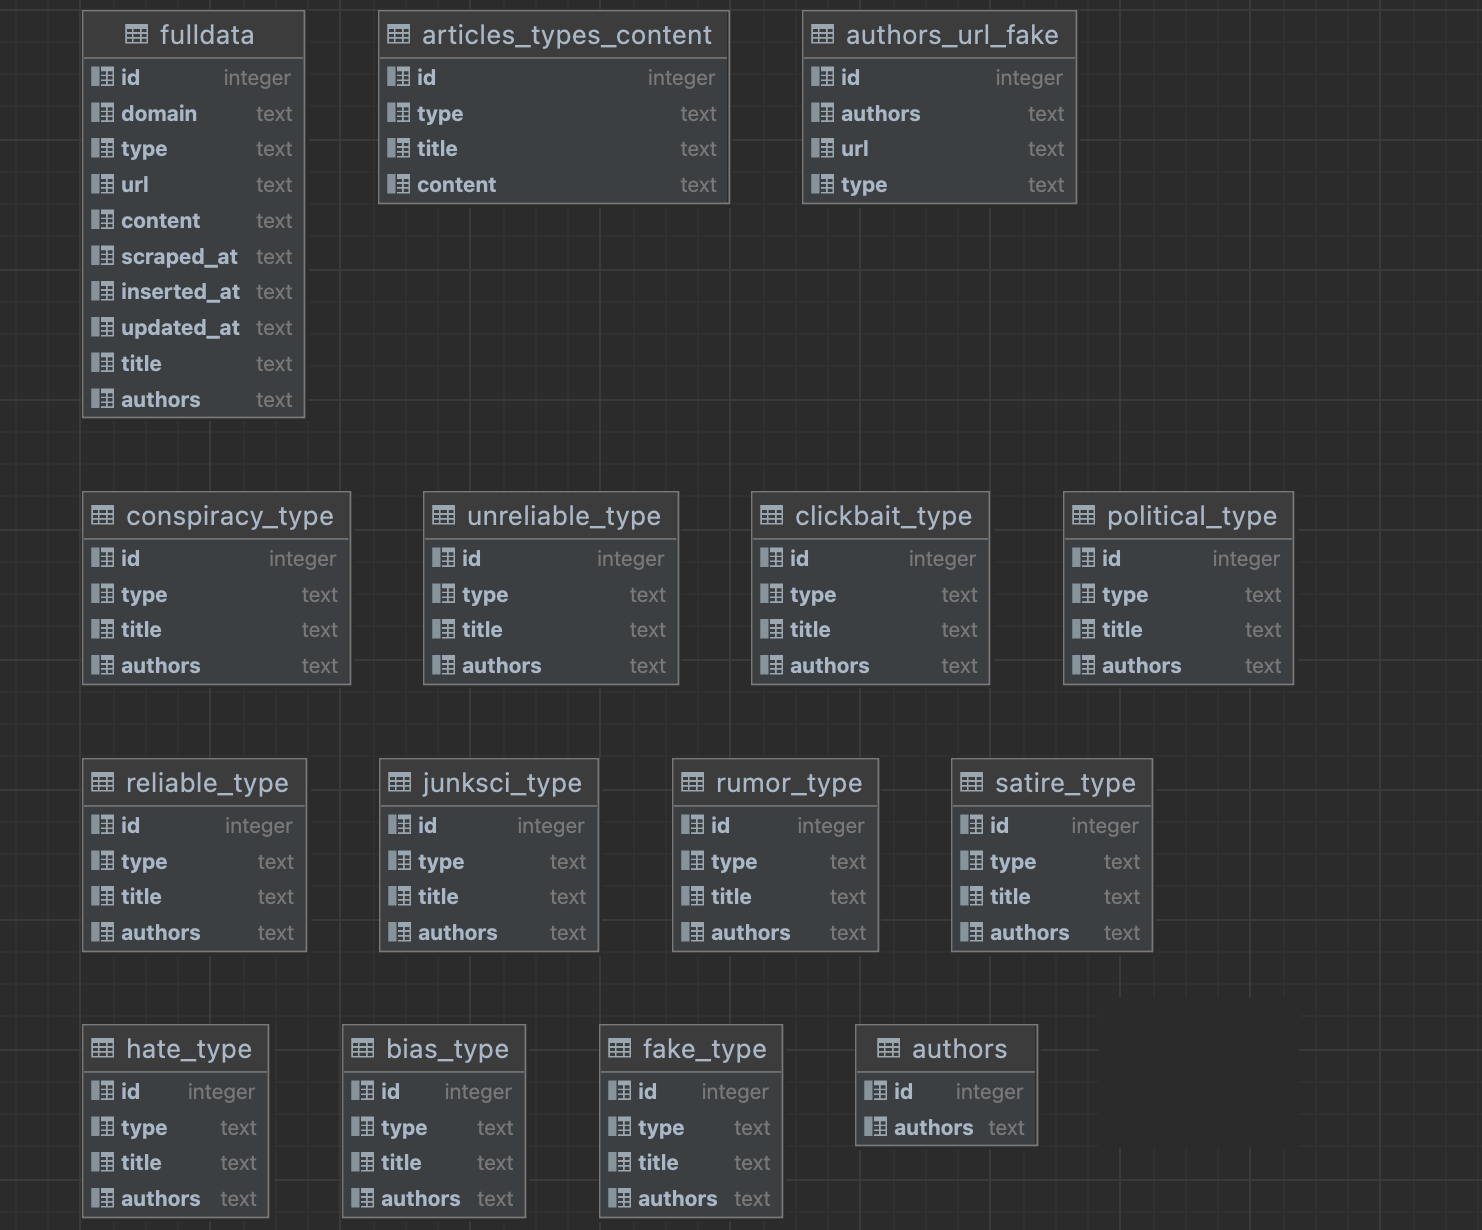

In [ ]:
display.Image("/work/relation.png")

# Task 2

BNCF form is a way to decomposition our relations to minimize anomalies 

Our relations: 

fulldata (contains all columns):
attributes: id, domain, type, url, content, scraped_at, inserted_at, updated_at, title, authors &nbsp;
functional dependencies: everything is functional dependant on id, there is a multivalued dependency from domain, authors, content, title to url&nbsp;. There is a transitive functional dependency from id -> url, and url -> content. So id has a transitive functional dependency to content. 
primary keys: id (since there are no duplicates, and it uniquely identify every row in the table) and url (since url is completely unique)&nbsp;
Is it in BCNF form? No, since id and url point to eachother. To decompose the relations and fulfill the BCNF form, we need to divide the id and url. &nbsp; 

articles_types_content: 
attributes: id, type, title, content
functional dependencies: everything is functional dependant on id
primary keys: id&nbsp;
BCNF form? Yes&nbsp;&nbsp;


authors_url_fake:
attributes: id, authors, url, type
functional dependencies: everything is functional dependant on id&nbsp;
primary keys: id
BCNF form? &nbsp;No, since id and url point to eachother. To fulfill the requirements for BCNF form, we need to divide the id and url, so the super keys does not point to one another.


We have 11 similar relational tables that only differ in terms of different types (whether the article is conspiracy, unreliable etc.)
General relation for all 11:&nbsp;
xxx_type&nbsp;
attributes: id, type, title, authors&nbsp;
functional dependencies: everything is functional dependant on id&nbsp;
primary keys: id&nbsp;
BCNF form? Yes

authors:
attributes: id, authors
functional dependencies: authors are(/is?) dependant on id
primary keys: id
BNCF form? Yes, since authors can have different articles and names are not unique and can occur multiple times from different persons. &nbsp;

&nbsp;&nbsp;&nbsp;&nbsp;

For the relationstable to be in BCNF form, two conditions must be met:
- It should be in the 3rd Normal form&nbsp;
- For any dependency A -&gt; B, A should be a super key&nbsp;

# Task 3

### Task 3.1

Since all entries in the database are scraped at 2018-01-25 there is no need to address this in the SQL query. This leads to a query formulated as: 

In [ ]:
CREATE TABLE task3_1 AS (SELECT DISTINCT domain FROM fulldata WHERE type = 'reliable'). 

This creates a new table from the fulldata table taking the domain column only selecting the entries with type 'reliable'. This results in a table consisting of the domains with only one of each entry (because of the DISTINCT statement). 

The domains containing reliable articles are 'christianpost.com', 'consortiumnews.com' and 'nutritionfacts.com'

### Task 3.2

Listing the most prolific author of fake news articles requires a table with authors of fake news articles. Initially creating a table of such authors and finding the most prolific one resulted in the author '&lt;null&gt;' since not all articles has an author. 

This lead to us creating a new table containing articles with authors only. This was done with the SQL query:

In [ ]:
CREATE TABLE fake_no_null AS (SELECT id, type, title, authors FROM fulldata
WHERE type = 'fake' AND authors IS NOT NULL)

Now finding the most prolific author was done with the SQL query:

In [ ]:
CREATE TABLE task3_2 AS (SELECT authors, COUNT(*) as count FROM fake_no_null 
GROUP BY authors HAVING COUNT(*) = 
(SELECT MAX(count) FROM (SELECT authors, COUNT(*) as count 
FROM fake_no_null GROUP BY authors) fake_no_null)) 

Here a new table task3_2 is created by selecting the author column from the newly created fake_no_null column and setting the variable 'count' to the maximum entry of the author column as well as listing the most prolific author.

The result of this query was the author John Rolls with a count of 1138 occurrences. 

### Task 3.3

Since we want to search in the meta keywords that are not empty we first set the empty meta keywords to NULL by:

In [ ]:
UPDATE fulldata SET meta_keywords = NULL
WHERE meta_keywords = '['''']'

Now we want to find the pairs of meta keywords and their corresponding Id's. This is done by:

In [ ]:
SELECT meta_keywords, COUNT(meta_keywords)
FROM fulldataGROUP BY meta_keywordsHAVING COUNT(meta_keywords) > 1)

A snippet of the resulting table of pairs is seen below. 

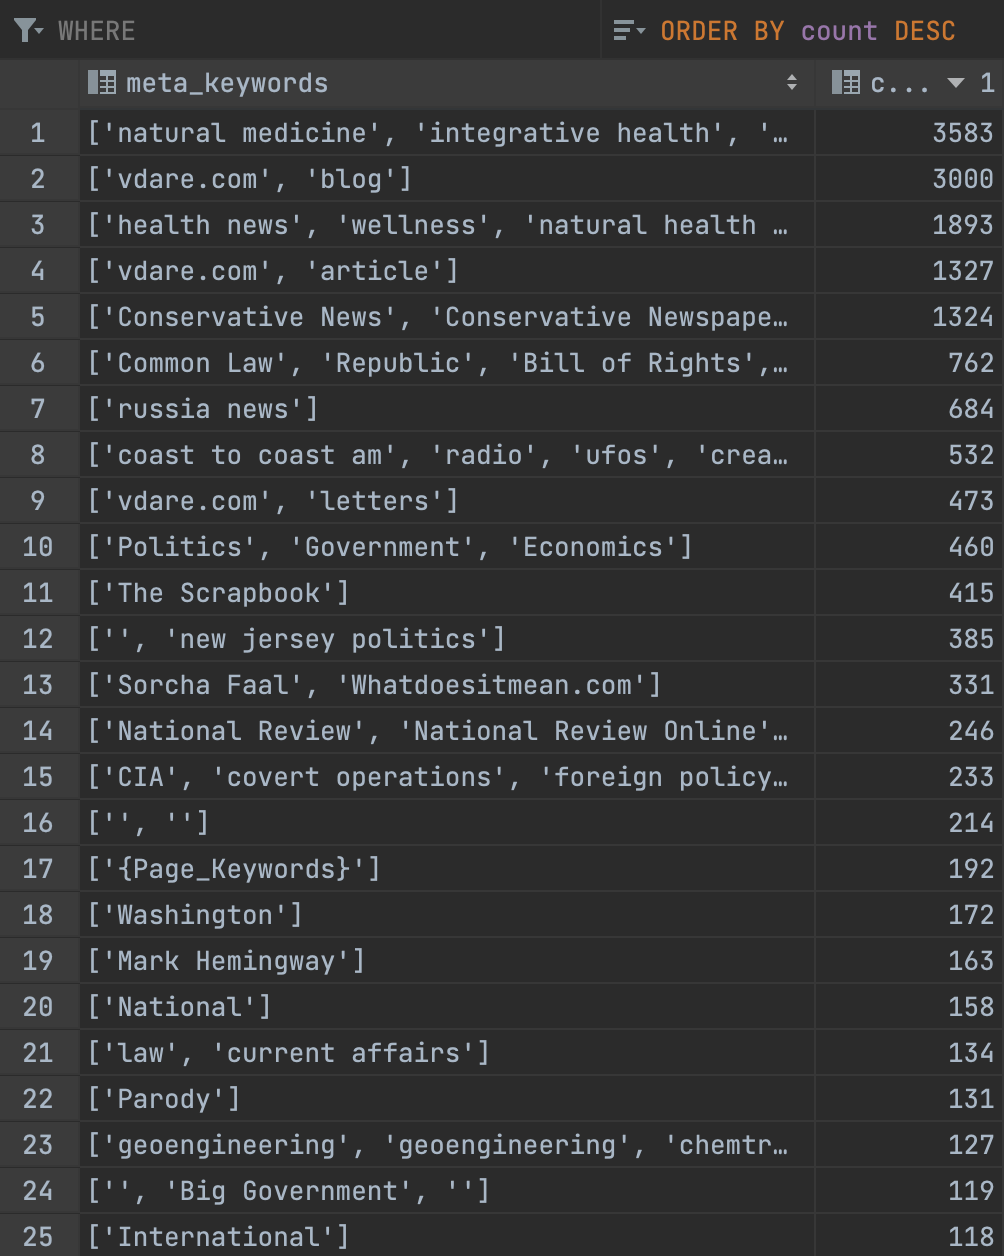

In [ ]:
display.Image("/work/task33.png")

# Task 4

Database queries: 

### Which domains writes fake news articles and which domains writes political articles? Which is the dominant one?

To find out which domains contain either a fake or political type a new table is created called 'task4_1' here the following SQL query is formulated to sort the domains from the other types:


In [ ]:
CREATE TABLE task4_1 AS(SELECT DISTINCT domain, type FROM fulldata 
WHERE type = 'fake' OR type = 'political')

Now the different domains can be read from the table. Furthermore the count of each domain type can be counted by formulating the SQL queries: 


In [ ]:
SELECT COUNT (type) FROM task4_1 WHERE type = 'fake')
 
SELECT COUNT(type) FROM task4_1 WHERE type = 'political')

Here we see that there are 21 fake news domains and 51 politcal domains, why there are more domains writing political articles than fake. 

### How many articles of each type are present in the database?

The number of each article of each type corresponds to the count of each type in the database. This count can be obtained with SQL query:


In [ ]:
SELECT type, COUNT(*) FROM fulldata GROUP BY type

This gives us an output displayed in the picture below:

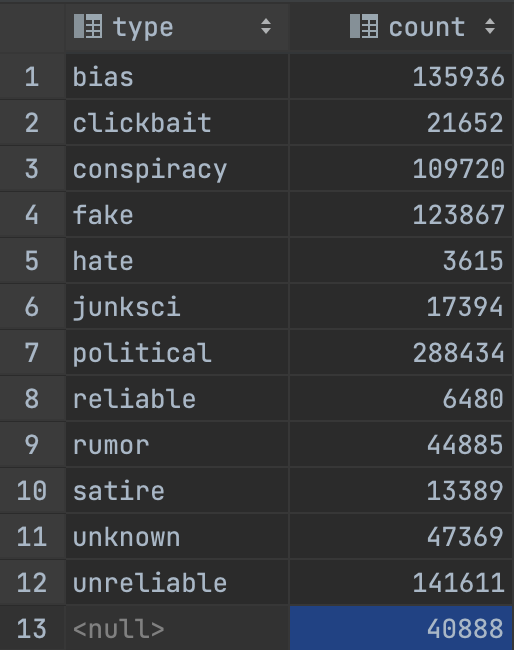

In [ ]:
display.Image("/work/task4.png")

### How many time does 'Trump' occur in articles and how many of these are fake news? Also comparing to political articles 

Firstly a table is created with all article titles and their type with content containing the word 'trump' is created. This is done with the following SQL query:


In [ ]:
CREATE TABLE task4_3 AS(SELECT title, type FROM fulldata WHERE content LIKE '%trump%')

Now the total amount of entries in the table can be counted by the SQL query:

In [ ]:
SELECT COUNT (title) FROM task4_3

This results in 14218 articles. Now the amount of fake news can be counted by:

In [ ]:
SELECT COUNT (type) FROM task4_3 WHERE type = 'fake'

This yields 1909 which results in a 1909/14218*100 = 13.4% percentage of the trump articles. This is maybe or maybe not a lot (could be interesting to analyze trumps tweets or speeches alone and match them with words found mainly in fake news articles). Comparing with the percentage of political articles:

In [ ]:
SELECT COUNT (type) FROM task4_3 WHERE type = 'political'

it shows that it is 8750/14218 = 61.5% of the articles are politcal. This makes sense since trump is a politician and people write politcal articles about political persons. 

### Obstacles throughout the assignment

- loading the full database from Github
- connecting Visual Studio to PostgreSQL to DataGrip, where we then chose to upload the csv file directly to DataGrip
- NB: We both tried downloading the "news.csv.z01", used "The Unarchiver" on the file, and then got                 "news_cleaned_2018_02_13.csv" which weighed 3,19GB. When we decompressed the file, we bot got an error "Incomplete file".
To create our table like we did in the news corpus sample, we first need to inspect the columns to work on the data, but both of us couldn't open the file. Neither with excel, or textedit.